# 1) Importando as bibliotecas e lendo os dados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)})

In [3]:
df = pd.read_csv("kc_house_data.csv")
df["date"] = pd.to_datetime(df["date"])

# 2) Tratamento dos Dados

Arredondando os valores das variáveis "bedrooms" e "bathrooms".

In [4]:
df[["bedrooms","bathrooms"]] = df[["bedrooms","bathrooms"]].apply(round)

Tirando as linhas em que a coluna "id" está duplicada, mantendo a data da última compra.

In [5]:
df.sort_values(by = "date",inplace = True)
df2 = df.drop_duplicates(subset = "id", keep = "last").copy()

Observando-se os boxplots das variáveis "bathrooms" e "bedrooms", nota-se que há um valor muilto alto em "bedrooms", de 33.

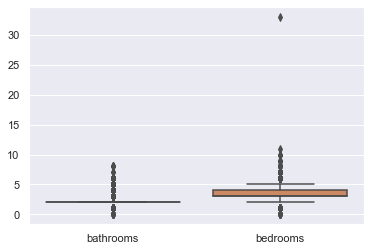

In [6]:
sns.boxplot(data = df2[["bathrooms", "bedrooms"]])
plt.show()

Calculando o metro quadrado desse imóvel, nota-se um valor de 150 m2, o que não é condizente com uma quantidade absurda de 33 quartos. Optei por retirar essa linha, visto que pode ser um erro de preenchimento dos dados.

In [7]:
df2[df2["bedrooms"] == df2["bedrooms"].max()]["sqft_living"]*0.092903

15870    150.50286
Name: sqft_living, dtype: float64

In [8]:
i = df2[df2["bedrooms"] == df2["bedrooms"].max()].index
df2.drop(i, inplace = True)
df2["bedrooms"].max()

11

In [10]:
df2.to_csv("C:/Users/victo/Desktop/Comunidade DS/Python do zero ao DS/datasets/kc_house_data_cleaned.csv")

# 3) Respondendo as perguntas de negócio.

Quais imóveis comprar.

In [8]:
median = df2[["zipcode","price"]].groupby("zipcode").median().reset_index()
median.rename(columns={"price":"median_price_zipcode"}, inplace = True)
df3 = pd.merge(df2, median, on = "zipcode", how = "inner")

In [9]:
df3["status"] = np.where((df3["price"] < df3["median_price_zipcode"]) & 
                         (df3["condition"] >=3),"compra","não compra")

In [10]:
df4 = df3[df3["status"] == "compra"].copy()

Qual o preço de revenda.

In [11]:
df4['season'] = df4['date'].dt.month.apply( lambda x: 'spring' if (x >= 3) & (x <=5 ) else 
                                               'summer' if ( x >= 6) & ( x <= 8 ) else
                                               'autumn' if ( x >= 9 ) & ( x <= 11 ) else 'winter' )

In [12]:
median_season = df4[["zipcode","price","season"]].groupby(["zipcode","season"]).median().reset_index()
median_season.rename(columns={"price":"median_price_season"}, inplace = True)
df5 = pd.merge(df4, median_season, on = ["zipcode","season"], how = "inner")

In [13]:
df5["price_sell"] = np.where(df5["price"] < df5["median_price_season"],df5["price"]*1.30,df4["price"]*1.10)

In [14]:
df4[["zipcode","price","season"]].groupby(["zipcode","season"]).median()

price
zipcode season          
98001   autumn  217500.0
        spring  210500.0
        summer  213300.0
        winter  228250.0
98002   autumn  195250.0
...                  ...
98198   winter  220000.0
98199   autumn  511200.0
        spring  543115.0
        summer  520000.0
        winter  565000.0

[280 rows x 1 columns]

In [15]:
df5["profit"] = df5["price_sell"] - df5["price"]

In [16]:
df5["price_sell"].sum()

4560966465.0

In [17]:
df5["price"].sum()

4079586744.0

In [18]:
df5["profit"].sum()

481379721.0000001

# 4) Hipóteses de negócio

H1: Imóveis que possuem vista para água, são 30% mais
caros, na média.

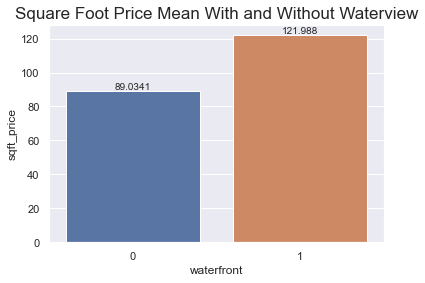

In [19]:
df2["sqft_price"] = df2["price"] / df["sqft_lot"]
ax = sns.barplot(data = df2, x = "waterfront",y = "sqft_price", ci=None)
ax.set_title('Square Foot Price Mean With and Without Waterview', fontsize = 17)
plt.ticklabel_format(style='plain', axis='y')
for i in ax.containers:
    ax.bar_label(i,)



H2: Imóveis com data de construção menor que 1955, são
50% mais baratos, na média.

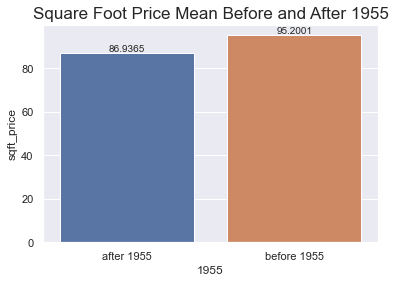

In [20]:
df2["1955"] = df2["yr_built"].apply( lambda x: 'before 1955' if (x < 1955) else 
                                           "after 1955")
ax = sns.barplot(data = df2, x = "1955",y = "sqft_price", ci=None)
ax.set_title('Square Foot Price Mean Before and After 1955', fontsize = 17)
plt.ticklabel_format(style='plain', axis='y')
for i in ax.containers:
    ax.bar_label(i,)

H3: Imóveis sem porão possuem sqft_lot 50%
maiores do que com porão.

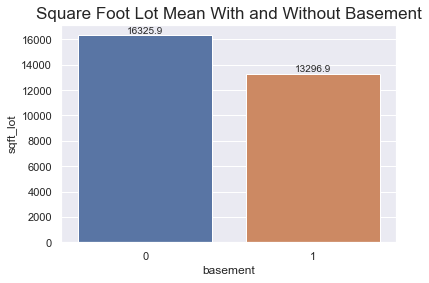

In [21]:
df2["basement"] = df2["sqft_basement"].apply( lambda x: 1 if (x != 0) else 0)
ax = sns.barplot(data = df2, x = "basement",y = "sqft_lot", ci=None)
ax.set_title('Square Foot Lot Mean With and Without Basement', fontsize = 17)
plt.ticklabel_format(style='plain', axis='y')
for i in ax.containers:
    ax.bar_label(i,)
                                        

H4: A quantidade de quartos tem maior correlação com o preço do que a quantidade de banheiros.

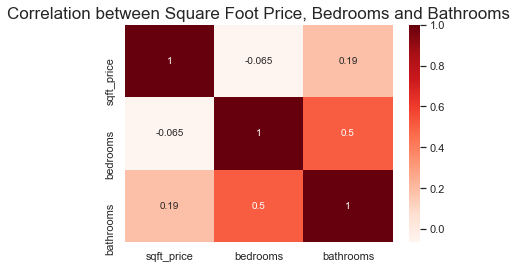

In [22]:
ax = sns.heatmap(df2[["sqft_price","bedrooms","bathrooms"]].corr(),cmap="Reds",annot=True)
ax.set_title('Correlation between Square Foot Price, Bedrooms and Bathrooms', fontsize = 17)
plt.show()

H5: O preço dos imóveis aumenta ao menos 5% ano a ano (YoY) após a construção.

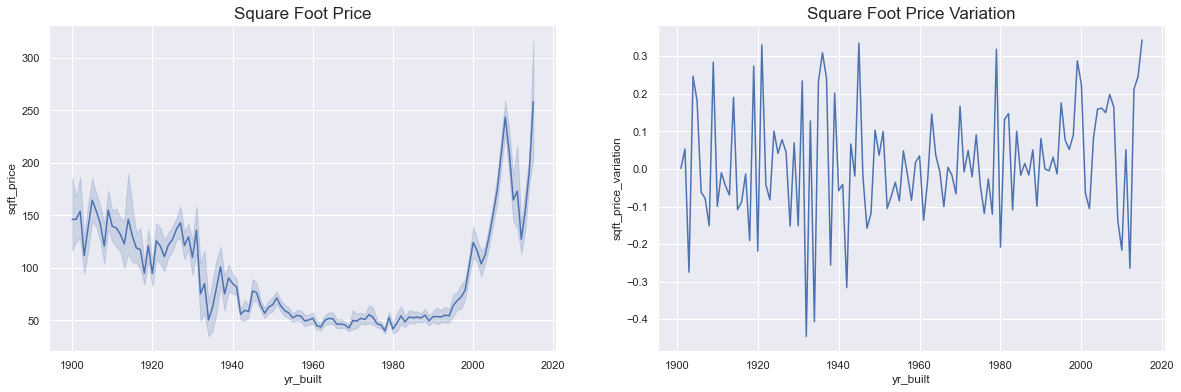

In [24]:
df_year = df2[["sqft_price","yr_built"]].groupby("yr_built").mean()
df_year = df_year.pct_change().reset_index()
df_year.rename({"sqft_price": "sqft_price_variation"}, axis='columns', inplace=True)

fig, ax =plt.subplots(1,2)

sns.lineplot(data=df2, y = "sqft_price", x ="yr_built", ax =ax
             [0]).set_title('Square Foot Price', fontsize = 17)

sns.lineplot(data=df_year, y = "sqft_price_variation", x ="yr_built", ax =ax
             [1]).set_title('Square Foot Price Variation', fontsize = 17)

plt.rcParams["figure.figsize"] = (20,6)

plt.show()
